Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
check
Score of LogisticRegression for training set: 0.6145.
Score of LogisticRegression for test set: 0.5077.
Training a RandomForestClassifier with PCA...
Trained RandomForestClassifier in 0.2 minutes
Calibrating probabilities of classifier...
Calibrated CalibratedClassifierCV in 0.0 minutes
Made predictions in 0.0182 seconds
Score of CalibratedClassifierCV for training set: 0.9218.
Made predictions in 0.0156 seconds
Score of CalibratedClassifierCV for test set: 0.5231.
Made predictions in 0.0183 seconds
Made predictions in 0.0153 seconds
Training a AdaBoostClassifier with PCA...
Trained AdaBoostClassifier in 0.6 minutes
Calibrating probabilities of classifier...
Calibrated CalibratedClassifierCV in 0.0 minutes
Made predictions in 0.0244 seconds
Score of CalibratedClassifierCV for training set: 0.6034.
Made predictions in 0.0205 seconds
Score of CalibratedCl

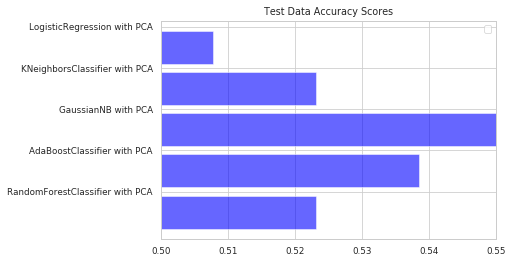

In [1]:
## Importing required libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from time import time
from sklearn.decomposition import PCA, FastICA
from sklearn.pipeline import Pipeline
from google.colab import drive, files
import warnings

warnings.simplefilter("ignore")
#drive.mount('/content/drive')
#data directory
path1 = '/content/drive/My Drive/data/'
features = pd.read_pickle(path1+'/features.pkl')
database = path1+'database.sqlite'
conn = sqlite3.connect(database)
#Fetching required data tables
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match;", conn)
#Reduce match data to fulfill run time requirements
rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id", 
        "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
        "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7", 
        "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
        "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]
match_data.dropna(subset = rows, inplace = True)
match_data = match_data.tail(1500)

inputs = pd.read_pickle('/content/drive/My Drive/data/inputs.pkl')
def explore_data(features, inputs, path):
    ''' Explore data by plotting KDE graphs. '''
    
    #Define figure subplots
    fig = plt.figure(1)
    fig.subplots_adjust(bottom= -1, left=0.025, top = 2, right=0.975)
    
    #Loop through features    
    i = 1
    for col in features.columns:
        
        #Set subplot and plot format        
        sns.set_style("whitegrid")
        sns.set_context("paper", font_scale = 0.5, rc={"lines.linewidth": 1})
        plt.subplot(7,7,0 + i)
        j = i - 1
        
        #Plot KDE for all labels
        sns.distplot(inputs[inputs['label'] == 'Win'].iloc[:,j], hist = False, label = 'Win')
        sns.distplot(inputs[inputs['label'] == 'Draw'].iloc[:,j], hist = False, label = 'Draw')
        sns.distplot(inputs[inputs['label'] == 'Defeat'].iloc[:,j], hist = False, label = 'Defeat')
        plt.legend();
        i = i + 1
    
    #Define plot format    
    DefaultSize = fig.get_size_inches()
    fig.set_size_inches((DefaultSize[0]*1.2, DefaultSize[1]*1.2))

    plt.show()
    
    #Compute and print label weights
    labels = inputs.loc[:,'label']
    class_weights = labels.value_counts() / len(labels)
    print(class_weights)

def train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs, use_grid_search = True, 
                     best_components = None, best_params = None):
    ''' Fits a classifier to the training data. '''
    
    #Start the clock, train the classifier, then stop the clock
    start = time()
    
    #Check if grid search should be applied
    if use_grid_search == True: 
        
        #Define pipeline of dm reduction and classifier
        estimators = [('dm_reduce', dm_reduction), ('clf', clf)]
        pipeline = Pipeline(estimators)
        
        #Grid search over pipeline and return best classifier
        grid_obj = model_selection.GridSearchCV(pipeline, param_grid = params, scoring = scorer, cv = cv_sets, n_jobs = jobs)
        grid_obj.fit(X_train, y_train)
        best_pipe = grid_obj.best_estimator_
    else:
         #Use best components that are known without grid search        
        estimators = [('dm_reduce', dm_reduction(n_components = best_components)), ('clf', clf(best_params))]
        pipeline = Pipeline(estimators)        
        best_pipe = pipeline.fit(X_train, y_train)
        
    end = time()
    
    #Print the results
    print("Trained {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    #Return best pipe
    return best_pipe

def train_calibrate_predict(clf, dm_reduction, X_train, y_train, X_calibrate, y_calibrate, X_test, y_test, cv_sets, params, scorer, jobs, 
                            use_grid_search = True, **kwargs):
    ''' Train and predict using a classifer based on scorer. '''
    
    #Indicate the classifier and the training set size
    print("Training a {} with {}...".format(clf.__class__.__name__, dm_reduction.__class__.__name__))
    
    #Train the classifier
    best_pipe = train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs)
    
    #Calibrate classifier
    print("Calibrating probabilities of classifier...")
    start = time()    
    clf = CalibratedClassifierCV(best_pipe.named_steps['clf'], cv= 'prefit', method='isotonic')
    clf.fit(best_pipe.named_steps['dm_reduce'].transform(X_calibrate), y_calibrate)
    end = time()
    print("Calibrated {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    # Print the results of prediction for both training and testing
    print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_train, y_train)))
    print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_test, y_test)))
    
    #Return classifier, dm reduction, and label predictions for train and test set
    return clf, best_pipe.named_steps['dm_reduce'], predict_labels(clf, best_pipe, X_train, y_train), predict_labels(clf, best_pipe, X_test, y_test)
        
def convert_odds_to_prob(match_odds):
    ''' Converts bookkeeper odds to probabilities. '''
    
    #Define variables
    match_id = match_odds.loc[:,'match_api_id']
    bookkeeper = match_odds.loc[:,'bookkeeper']    
    win_odd = match_odds.loc[:,'Win']
    draw_odd = match_odds.loc[:,'Draw']
    loss_odd = match_odds.loc[:,'Defeat']
    
    #Converts odds to prob
    win_prob = 1 / win_odd
    draw_prob = 1 / draw_odd
    loss_prob = 1 / loss_odd
    
    total_prob = win_prob + draw_prob + loss_prob
    
    probs = pd.DataFrame()
    
    #Define output format and scale probs by sum over all probs
    probs.loc[:,'match_api_id'] = match_id
    probs.loc[:,'bookkeeper'] = bookkeeper
    probs.loc[:,'Win'] = win_prob / total_prob
    probs.loc[:,'Draw'] = draw_prob / total_prob
    probs.loc[:,'Defeat'] = loss_prob / total_prob
    
    #Return probs and meta data
    return probs

def predict_labels(clf, best_pipe, features, target):
    ''' Makes predictions using a fit classifier based on scorer. '''
    
    #Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(best_pipe.named_steps['dm_reduce'].transform(features))
    end = time()
    
    #Print and return results
    print("Made predictions in {:.4f} seconds".format(end - start))
    return accuracy_score(target.values, y_pred)
  
def find_best_classifier(classifiers, dm_reductions, scorer, X_t, y_t, X_c, y_c, X_v, y_v, cv_sets, params, jobs):
    ''' Tune all classifier and dimensionality reduction combiantions to find best classifier. '''
    
    #Initialize result storage
    clfs_return = []
    dm_reduce_return = []
    train_scores = []
    test_scores = []
    
    #Loop through dimensionality reductions
    for dm in dm_reductions:
        
        #Loop through classifiers
        for clf in clfs:
            
            #Grid search, calibrate, and test the classifier
            clf, dm_reduce, train_score, test_score = train_calibrate_predict(clf = clf, dm_reduction = dm, X_train = X_t, y_train = y_t,
                                                      X_calibrate = X_c, y_calibrate = y_c,
                                                      X_test = X_v, y_test = y_v, cv_sets = cv_sets,
                                                      params = params[clf], scorer = scorer, jobs = jobs, use_grid_search = True)
            
            #Append the result to storage            
            clfs_return.append(clf)
            dm_reduce_return.append(dm_reduce)
            train_scores.append(train_score)
            test_scores.append(test_score)
    
    #Return storage
    return clfs_return, dm_reduce_return, train_scores, test_scores

def plot_confusion_matrix(y_test, X_test, clf, dim_reduce, path, cmap=plt.cm.Blues, normalize = False):    
    ''' Plot confusion matrix for given classifier and data. '''
    
    #Define label names and get confusion matrix values
    labels = ["Win", "Draw", "Defeat"]
    cm = confusion_matrix(y_test, clf.predict(dim_reduce.transform(X_test)), labels)
    
    #Check if matrix should be normalized
    if normalize == True:
        
        #Normalize
        cm = cm.astype('float') / cm.sum()
        
    #Configure figure
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    title= "Confusion matrix of a {} with {}".format(best_clf.base_estimator.__class__.__name__, best_dm_reduce.__class__.__name__)   
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
    #Print classification report
    y_pred = clf.predict(dim_reduce.transform(X_test))
    print(classification_report(y_test, y_pred)) 

def compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False):
    ''' Map bookkeeper and model probabilities. '''
    
    #Create features and labels for given matches
    feables = create_feables(matches, fifa_data, bk, get_overall = True, verbose = False)
    
    #Ensure consistency
    match_ids = list(feables['match_api_id'])
    matches = matches[matches['match_api_id'].isin(match_ids)]
    
    #Get bookkeeper probabilities
    if verbose == True:
        print("Obtaining bookkeeper probabilities...")
    bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
    bookkeeper_probs.reset_index(inplace = True, drop = True)
    
    inputs = feables.drop('match_api_id', axis = 1)
    labels = inputs.loc[:,'label']
    features = inputs.drop('label', axis = 1)
    
    #Get model probabilities
    if verbose == True:
        print("Predicting probabilities based on model...")
    model_probs = pd.DataFrame()
    label_table = pd.Series()
    temp_probs = pd.DataFrame(clf.predict_proba(dim_reduce.transform(features)), columns = ['win_prob', 'draw_prob', 'defeat_prob'])
    for bookkeeper in bookkeepers:
        model_probs = model_probs.append(temp_probs, ignore_index = True)
        label_table = label_table.append(labels)
    model_probs.reset_index(inplace = True, drop = True)
    label_table.reset_index(inplace = True, drop = True)
    bookkeeper_probs['win_prob'] = model_probs['win_prob']
    bookkeeper_probs['draw_prob'] = model_probs['draw_prob']
    bookkeeper_probs['defeat_prob'] = model_probs['defeat_prob']
    bookkeeper_probs['label'] = label_table 
    
    #Aggregate win probabilities for each match
    wins = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Win', 'win_prob', 'label']]
    wins.loc[:, 'bet'] = 'Win'
    wins = wins.rename(columns = {'Win':'bookkeeper_prob',
                                  'win_prob': 'model_prob'})
                                  
    #Aggregate draw probabilities for each match
    draws = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Draw', 'draw_prob', 'label']]
    draws.loc[:, 'bet'] = 'Draw'
    draws = draws.rename(columns = {'Draw':'bookkeeper_prob',
                                  'draw_prob': 'model_prob'})
                                  
    #Aggregate defeat probabilities for each match
    defeats = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Defeat', 'defeat_prob', 'label']]
    defeats.loc[:, 'bet'] = 'Defeat'
    defeats = defeats.rename(columns = {'Defeat':'bookkeeper_prob',
                                  'defeat_prob': 'model_prob'})
    
    total = pd.concat([wins, draws, defeats])
    
    #Return total
    return total
    
def find_good_bets(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, percentile, prob_cap, verbose = False):
    ''' Find good bets for a given classifier and matches. '''
    
    #Compare model and classifier probabilities
    probs = compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False)
    probs.loc[:, 'prob_difference'] = probs.loc[:,"model_prob"] - probs.loc[:,"bookkeeper_prob"]
    
    #Sort by createst difference to identify most underestimated bets    
    values = probs['prob_difference']
    values = values.sort_values(ascending = False)
    values.reset_index(inplace = True, drop = True)
    
    if verbose == True:
        print("Selecting attractive bets...")
        
    #Identify choices that fulfill requirements such as positive difference, minimum probability and match outcome
    relevant_choices = probs[(probs.prob_difference > 0) & (probs.model_prob > prob_cap) & (probs.bet != "Draw")]
    
    #Select given percentile of relevant choices    
    top_percent = 1 - percentile
    choices = relevant_choices[relevant_choices.prob_difference >= relevant_choices.prob_difference.quantile(top_percent)]
    choices.reset_index(inplace = True, drop = True)
    
    #Return choices
    return choices

def get_reward(choice, matches):
    ''' Get the reward of a given bet. '''
    
    #Identify bet
    match = matches[matches.match_api_id == choice.match_api_id]
    bet_data = match.loc[:,(match.columns.str.contains(choice.bookkeeper))]
    cols = bet_data.columns.values
    cols[:3] = ['win','draw','defeat']
    bet_data.columns = cols
    
    #Identfiy bet type and get quota
    if choice.bet == 'Win':
        bet_quota = bet_data.win.values
    elif choice.bet == 'Draw':
        bet_quota = bet_data.draw.values
    elif choice.bet == 'Defeat':
        bet_quota = bet_data.defeat.values
    else:
        print("Error")
    
    #Check label and compute reward
    if choice.bet == choice.label:
        reward = bet_quota
    else:
        reward = 0
    
    #Return reward
    return reward
      
def execute_bets(bet_choices, matches, verbose = False):
    ''' Get rewards for all bets. '''    
    
    if verbose == True:
        print("Obtaining reward for chosen bets...")
    total_reward = 0
    total_invested = 0
    
    #Loop through bets
    loops = np.arange(0, bet_choices.shape[0])     
    for i in loops:
        
        #Get rewards and accumulate profit
        reward = get_reward(bet_choices.iloc[i,:], matches)
        total_reward = total_reward + reward
        total_invested += 1
    
    #Compute investment return
    investment_return = float(total_reward / total_invested) - 1
    
    #Return investment return
    return investment_return

def plot_training_results(clfs, dm_reductions, train_scores, test_scores, path):
    ''' Plot results of classifier training. '''
    
    #Set graph format
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale = 1, rc={"lines.linewidth": 1})
    ax = plt.subplot(111)
    w = 0.5
    x = np.arange(len(train_scores))
    ax.set_yticks(x + w)
    ax.legend((train_scores[0], test_scores[0]), ("Train Scores", "Test Scores"))
    names = []
    
    #Loop throuugh classifiers
    for i in range(0, len(clfs)): 
        
        #Define temporary variables        
        clf = clfs[i]
        clf_name = clf.base_estimator.__class__.__name__
        dm = dm_reductions[i]
        dm_name = dm.__class__.__name__
        
        #Create and store name
        name = "{} with {}".format(clf_name, dm_name)
        names.append(name)
        
    #Plot all names in horizontal bar plot
    ax.set_yticklabels((names))
    plt.xlim(0.5, 0.55)
    plt.barh(x, test_scores, color = 'b', alpha = 0.6)
    plt.title("Test Data Accuracy Scores")
    fig = plt.figure(1)
    
    plt.show()
    
def optimize_betting(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, match_data, fifa_data,
                     n_samples, sample_size, parameter_1_grid, parameter_2_grid, verbose = False):
    ''' Tune parameters of bet selection algorithm. '''
    
    #Generate data samples
    samples = []
    for i in range(0, n_samples):
        sample = match_data.sample(n = sample_size, random_state = 42)
        samples.append(sample)
    
    results = pd.DataFrame(columns = ["parameter_1", "parameter_2", "results"])
    row = 0
    
    #Iterate over all 1 parameter
    for i in parameter_1_grid:
        
        #Iterate over all 2 parameter
        for j in parameter_2_grid:
            
            #Compute average score over all samples
            profits = []
            for sample in samples:
                choices = find_good_bets(best_clf, best_dm_reduce, bk_cols_selected, bk_cols, sample, fifa_data, i, j)
                profit = execute_bets(choices, match_data)
                profits.append(profit)
            result = np.mean(np.array(profits))
            results.loc[row,"results"] = result
            results.loc[row,"parameter_1"] = i
            results.loc[row,"parameter_2"] = j
            row = row + 1
            if verbose == True: print("Simulated parameter combination: {}".format(row))
               
    #Return best setting and result
    best_result = results.ix[results['results'].idxmax()] 
    return best_result
    
    
def plot_bookkeeper_cf_matrix(matches, bookkeepers, path, verbose = False, normalize = True):
    ''' Plot confusion matrix of bookkeeper predictions. '''
    
    if verbose == True: print("Obtaining labels...")
    
    #Get match labels
    y_test_temp = matches.apply(get_match_label, axis = 1)
    
    if verbose == True: print("Obtaining bookkeeper probabilities...")
    
    #Get bookkeeper probabilities
    bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
    bookkeeper_probs.reset_index(inplace = True, drop = True)
    bookkeeper_probs.dropna(inplace = True)
    
    if verbose == True: print("Obtaining bookkeeper labels...")
    
    #Get bookkeeper labels
    y_pred_temp = pd.DataFrame()
    y_pred_temp.loc[:,'bk_label'] = bookkeeper_probs[['Win', 'Draw', 'Defeat']].idxmax(axis = 1)
    y_pred_temp.loc[:,'match_api_id'] = bookkeeper_probs.loc[:, 'match_api_id']
    
    if verbose == True: print("Plotting confusion matrix...")
    
    #Format data
    results = pd.merge(y_pred_temp, y_test_temp, on = 'match_api_id', how = 'left')
    y_test = results.loc[:, 'label']
    y_pred = results.loc[:, 'bk_label']
    
    #Generate confusion matrix
    labels = ["Win", "Draw", "Defeat"]
    cm = confusion_matrix(y_test, y_pred, labels) 
    
    #Check for normalization
    if normalize == True:
        cm = cm.astype('float') / cm.sum()
        
    #Plot confusion matrix
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    title = "Confusion matrix of Bookkeeper predictions!"   
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
    #Print classification report and accuracy score of bookkeepers
    print(classification_report(y_test, y_pred)) 
    print("Bookkeeper score for test set: {:.4f}.".format(accuracy_score(y_test, y_pred)))

start=time()
#Defining the number of jobs to be run in parallel during grid search
n_jobs=1   #Insert number of parallel jobs here

#Exploring the data and creating visualizations
labels = inputs.loc[:,'label']
features.head(5)
#feature_details = explore_data(features, inputs, path)

#Splitting the data into Train, Calibrate, and Test data sets
X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42, 
                                                                        stratify = labels)
X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate, test_size = 0.3, random_state = 42, 
                                                              stratify = y_train_calibrate)
print ("check")
#Creating cross validation data splits
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)
cv_sets.get_n_splits(X_train, y_train)

## Initializing all models and parameters
#Initializing classifiers
RF_clf = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')
AB_clf = AdaBoostClassifier(n_estimators = 200, random_state = 2)
GNB_clf = GaussianNB()
KNN_clf =  KNeighborsClassifier()
LOG_clf = linear_model.LogisticRegression(multi_class = "ovr", solver = "sag", class_weight = 'balanced')
clfs = [RF_clf, AB_clf, GNB_clf, KNN_clf, LOG_clf]

#Specficying scorer and parameters for grid search
feature_len = features.shape[1]
scorer = make_scorer(accuracy_score)
parameters_RF = {'clf__max_features': ['auto', 'log2'], 
                 'dm_reduce__n_components':[int(i) for i in np.arange(5, feature_len, np.around(feature_len/5))]}
parameters_AB = {'clf__learning_rate': np.linspace(0.5, 2, 5), 
                 'dm_reduce__n_components': [int(i) for i in np.arange(5, feature_len, np.around(feature_len/5))]}
parameters_GNB = {'dm_reduce__n_components': [int(i) for i in np.arange(5, feature_len, np.around(feature_len/5))]}
parameters_KNN = {'clf__n_neighbors': [3, 5, 10], 
                  'dm_reduce__n_components': [int(i) for i in np.arange(5, feature_len, np.around(feature_len/5))]}
parameters_LOG = {'clf__C': np.logspace(1, 1000, 5), 
                  'dm_reduce__n_components': [int(i) for i in np.arange(5, feature_len, np.around(feature_len/5))]}

parameters = {clfs[0]: parameters_RF,
              clfs[1]: parameters_AB,
              clfs[2]: parameters_GNB,
              clfs[3]: parameters_KNN,
              clfs[4]: parameters_LOG}
#Initializing dimensionality reductions
pca = PCA()
dm_reductions = [pca]  
## Training a baseline model and finding the best model composition using grid search
#Train a simple GBC classifier as baseline model
clf = LOG_clf
clf.fit(X_train, y_train)
print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train, clf.predict(X_train))))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_test, clf.predict(X_test))))

#Training all classifiers and comparing them
clfs, dm_reductions, train_scores, test_scores = find_best_classifier(clfs, dm_reductions, scorer, X_train, y_train, 
                                                                    X_calibrate, y_calibrate, X_test, y_test, cv_sets, 
                                                                      parameters, n_jobs)

#Plotting train and test scores
plot_training_results(clfs, dm_reductions, np.array(train_scores), np.array(test_scores), path = path)


The best classifier is a GaussianNB with PCA.


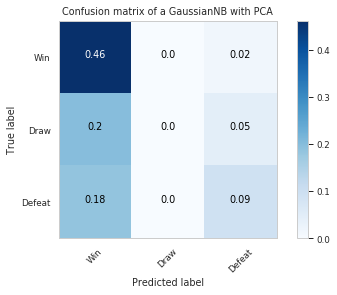

              precision    recall  f1-score   support

      Defeat       0.60      0.33      0.43        18
        Draw       0.00      0.00      0.00        16
         Win       0.55      0.97      0.70        31

    accuracy                           0.55        65
   macro avg       0.38      0.43      0.38        65
weighted avg       0.43      0.55      0.45        65



In [3]:
## Plotting a confusion matrix of the best model and the bookkeeper predictions
#Defining the best classifier and plotting a confusion matrix
best_clf = clfs[np.argmax(test_scores)]
best_dm_reduce = dm_reductions[np.argmax(test_scores)]
print("The best classifier is a {} with {}.".format(best_clf.base_estimator.__class__.__name__, best_dm_reduce.__class__.__name__)                              )
plot_confusion_matrix(y_test, X_test, best_clf, best_dm_reduce, path = path, normalize = True)

#Plotting a confusion matrix of bookkeepers
#plot_bookkeeper_cf_matrix(match_data, bk_cols, path, verbose = True, normalize = True)